In [1]:
%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *

import matplotlib.pyplot as plt
import progressbar
import random

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=50
dims_latent = 10                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cuda", 1)
train_transform = Compose([
    Resize(28),
    ToTensor(),
])
train_size=0.001


Cuda installed! Running on GPU 1 GeForce RTX 2080 Ti!


# MNIST Example

In [3]:
# Datasets and dataloaders
ds = MNIST("./", download=False, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

idx_5 = []
for i in range(len(ds)):
    if ds[i][1] == 5:
        idx_5.append(i)
        if len(idx_5) == 10:
            break
trainds = Subset(ds, idx_5)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())

Trainable Images: 10
torch.Size([1, 1, 28, 28]) 0.0 1.0


## Autoencoder

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...
N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 {'epoch': 0, 'train_l2_loss': 1528.070068359375}


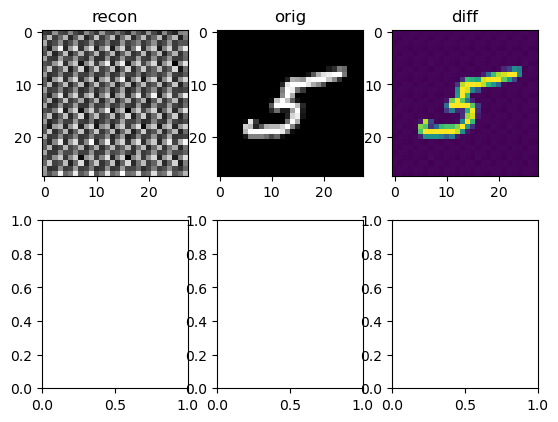

 20% (10 of 50) |####                    | Elapsed Time: 0:00:04 ETA:   0:00:12
 {'epoch': 10, 'train_l2_loss': 1370.060546875}


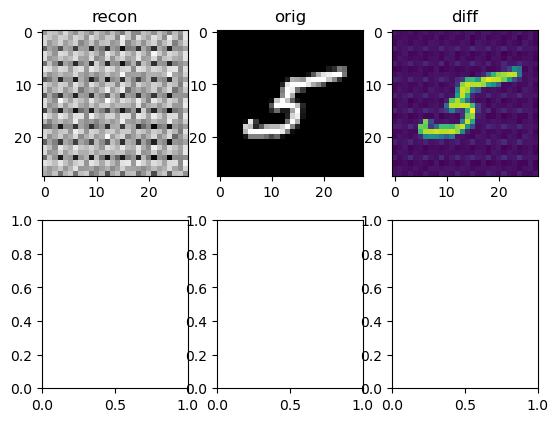

 40% (20 of 50) |#########               | Elapsed Time: 0:00:08 ETA:   0:00:13
 {'epoch': 20, 'train_l2_loss': 632.7865600585938}


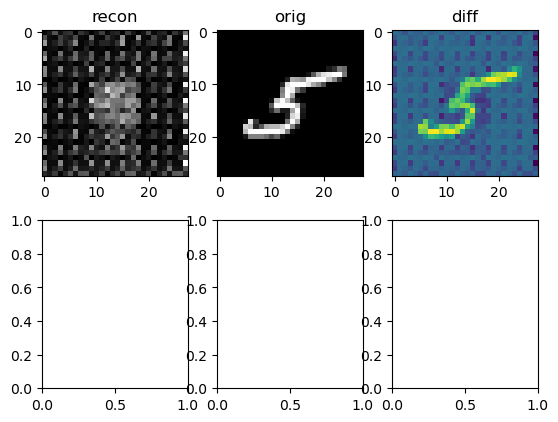

 60% (30 of 50) |##############          | Elapsed Time: 0:00:12 ETA:   0:00:06
 {'epoch': 30, 'train_l2_loss': 476.5955810546875}


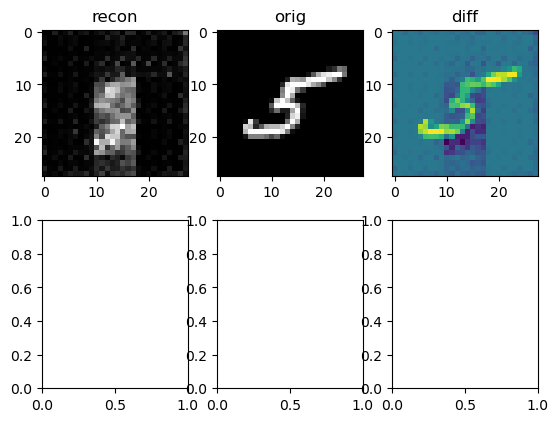

 80% (40 of 50) |###################     | Elapsed Time: 0:00:16 ETA:   0:00:03
 {'epoch': 40, 'train_l2_loss': 417.9772033691406}


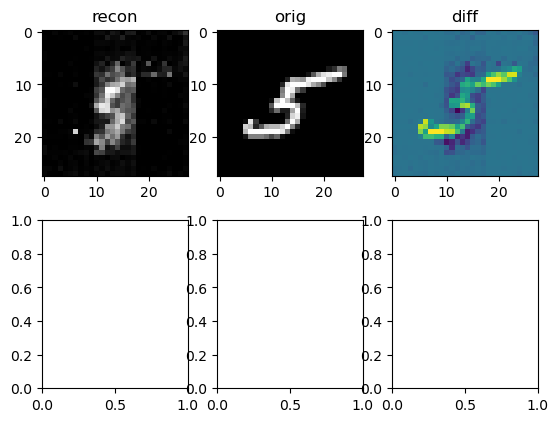

 98% (49 of 50) |####################### | Elapsed Time: 0:00:20 ETA:   0:00:00
 {'epoch': 49, 'train_l2_loss': 361.69744873046875}


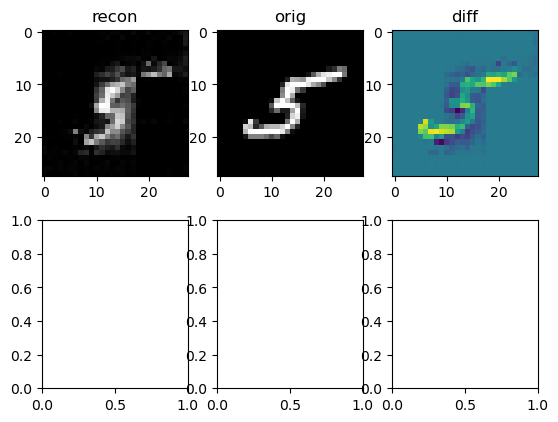

100% (50 of 50) |########################| Elapsed Time: 0:00:21 Time:  0:00:21


In [26]:
%autoreload 2
from networks import *
# Model and optimisers
model = ConvAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Losses
l2loss = nn.MSELoss(reduction="sum")

# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        epoch_loss, _ = train_ae(model, train_loader, optimizer, l2loss, device=device)
        bar.update(epoch)
            
        # Metric logs and plots
        log = {"epoch": epoch, "train_l2_loss":epoch_loss.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            # idx = random.randint(0, len(trainds))
            idx = -1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon = model(X)

            print("\n", log)
            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            plt.show()

## Variational Autoencoder

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...
N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 {'epoch': 0, 'train_loss': 1836.2672119140625, 'train_kl_loss': 51.53913116455078}


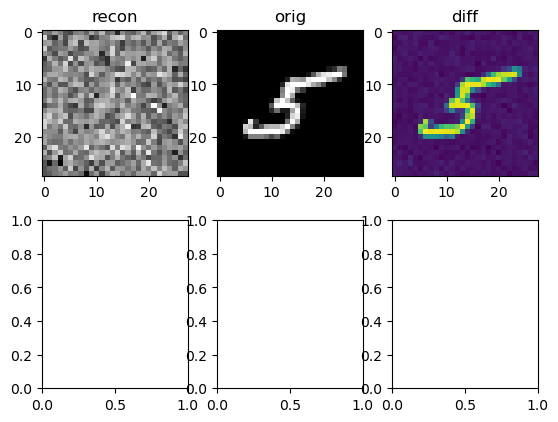

 20% (10 of 50) |####                    | Elapsed Time: 0:00:03 ETA:   0:00:12
 {'epoch': 10, 'train_loss': 421.3380126953125, 'train_kl_loss': 324.9024963378906}


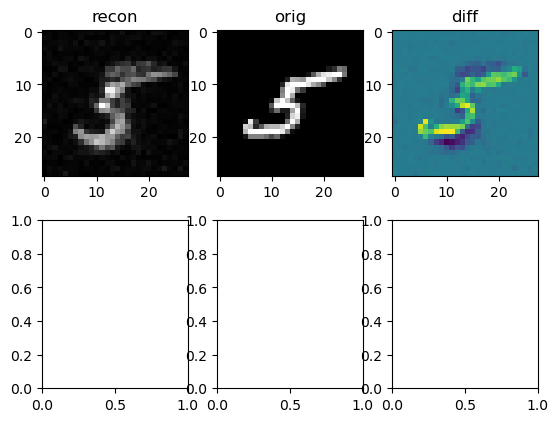

 40% (20 of 50) |#########               | Elapsed Time: 0:00:07 ETA:   0:00:08
 {'epoch': 20, 'train_loss': 378.8188171386719, 'train_kl_loss': 65.36956024169922}


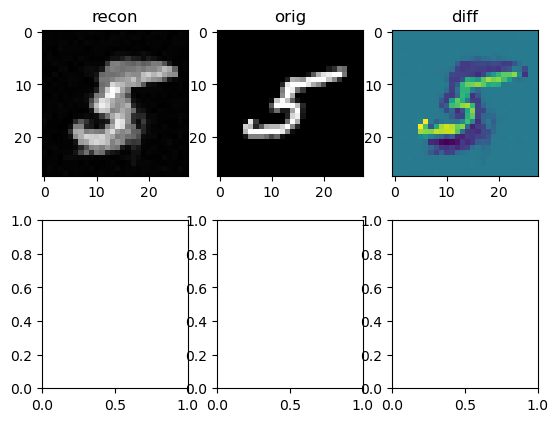

 60% (30 of 50) |##############          | Elapsed Time: 0:00:11 ETA:   0:00:06
 {'epoch': 30, 'train_loss': 356.93218994140625, 'train_kl_loss': 72.6861572265625}


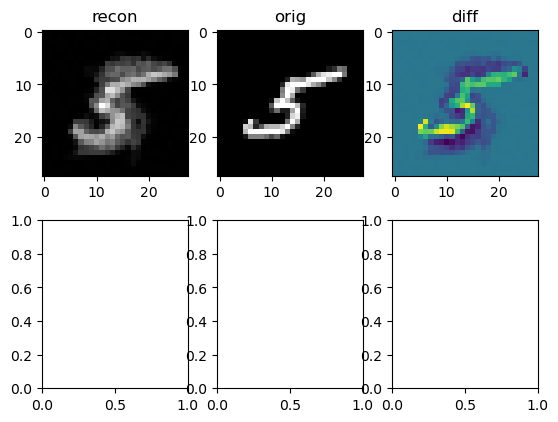

 80% (40 of 50) |###################     | Elapsed Time: 0:00:15 ETA:   0:00:03
 {'epoch': 40, 'train_loss': 340.6025390625, 'train_kl_loss': 56.862701416015625}


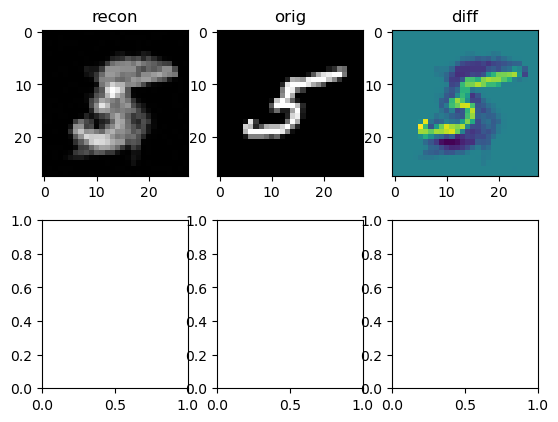

 98% (49 of 50) |####################### | Elapsed Time: 0:00:19 ETA:   0:00:00
 {'epoch': 49, 'train_loss': 286.800537109375, 'train_kl_loss': 82.52529907226562}


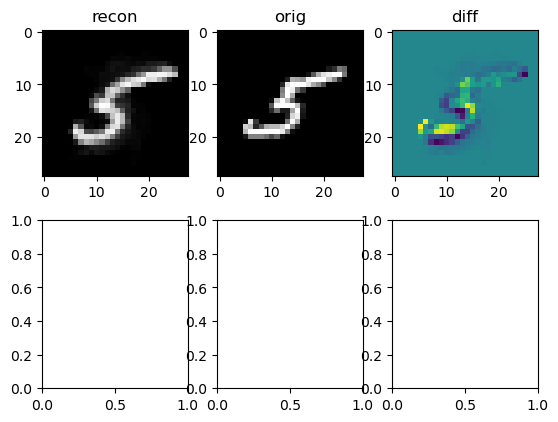

100% (50 of 50) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


In [4]:
# Model and optimisers
model = ConvVAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Losses
l2loss = nn.MSELoss(reduction="sum")

# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        epoch_loss, _, epoch_kl = train_vae(model, train_loader, optimizer, l2loss, device=device)
        bar.update(epoch)

        # Metric logs and plots
        log = {"epoch": epoch, "train_loss":epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            # idx = random.randint(0, len(trainds))
            idx = -1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon, _, _ = model(X)

            print("\n", log)
            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            plt.show()
